# 03. PyTorch Computer Vision

### Import the relevant dependencies

In [129]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")

PyTorch Version: 2.3.1
TorchVision Version: 0.18.1


In [130]:
import random
import numpy as np

def setup_seed(seed):
    # Fix random seed for CPU
    torch.manual_seed(seed)
    # Fix random seed for all CUDA (NVIDIA GPU) devices
    torch.cuda.manual_seed_all(seed)
    # Fix random seed for MPS (Apple Silicon) (only effective if MPS is available)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    # Fix random seeds for numpy and Python native random module
    np.random.seed(seed)
    random.seed(seed)
    # Enable deterministic algorithms for CUDA (ensure reproducibility of convolution etc.)
    torch.backends.cudnn.deterministic = True

# Set random seed
setup_seed(42)

### Let's get start with FashionMNIST (10 different image classes)

In [131]:
train_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    transform=ToTensor(),
    download=True
    )

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
    )

In [132]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

## Input and Output shapes of a CV model

In [133]:
image.shape

torch.Size([1, 28, 28])

Having 1 color channel means the image is grayscale.

In [134]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [135]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Visualize the data

Text(0.5, 1.0, '9')

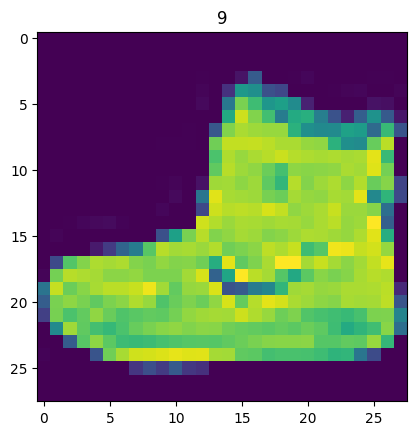

In [136]:
image, label = train_data[0]
plt.imshow(image.squeeze()) # plt.imshow(): Converts an array to an image and renders it.
# plt.show(): Displays all rendered content.
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

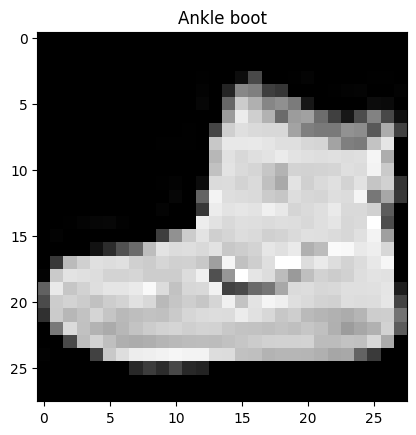

In [137]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

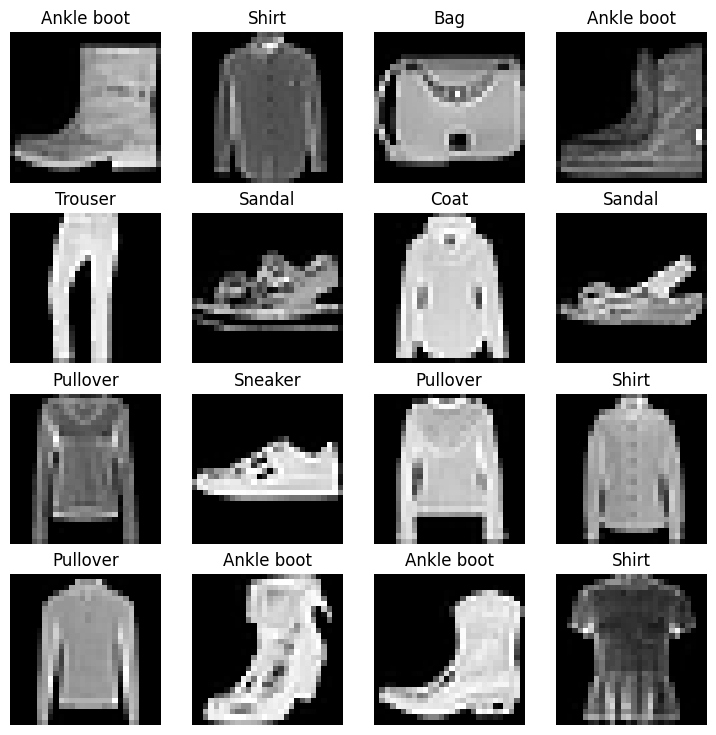

In [138]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Prepare Dataloader

For large datasets, it’s better to split data into batches based on computing power constraints. 

Batches additionally give the model more chances to improve its performance.

In [139]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # Train dataloader need to be shuffled

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x31cb7ad00>, <torch.utils.data.dataloader.DataLoader object at 0x160e7c460>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [140]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
# iter() creates an iterator, next() fetch elements from the iterator
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

21
Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


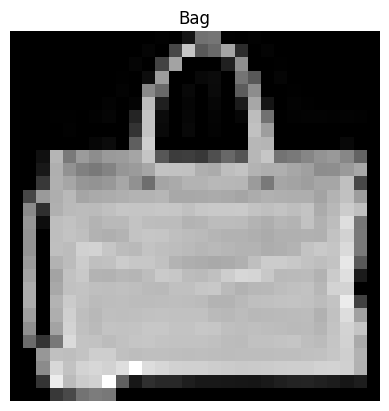

In [141]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
print(random_idx)
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis("off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [142]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


nn.Flatten() turns pixel data from height and width dimensions into a long feature vector.

In [143]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_shape),
            nn.Linear(hidden_shape, output_shape)
            )
        
    def forward(self, x):
        return self.layer_stack(x)

In [144]:
model_0 = FashionMNISTModelV0(784, 10, len(class_names))

model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [145]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.1)

In [146]:
from timeit import default_timer as Timer

def print_train_time(start, end, device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [147]:
from tqdm.auto import tqdm

train_time_start_on_cpu = Timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked ar {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

train_time_end_on_cpu = Timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked ar 0/60000 samples
Looked ar 12800/60000 samples
Looked ar 25600/60000 samples
Looked ar 38400/60000 samples
Looked ar 51200/60000 samples
Train loss: 0.59088 | Test loss: 0.49865, Test acc: 82.56%
Epoch: 1

Looked ar 0/60000 samples
Looked ar 12800/60000 samples
Looked ar 25600/60000 samples
Looked ar 38400/60000 samples
Looked ar 51200/60000 samples
Train loss: 0.47569 | Test loss: 0.48283, Test acc: 82.59%
Epoch: 2

Looked ar 0/60000 samples
Looked ar 12800/60000 samples
Looked ar 25600/60000 samples
Looked ar 38400/60000 samples
Looked ar 51200/60000 samples
Train loss: 0.45271 | Test loss: 0.48357, Test acc: 83.22%
Train time on cpu: 10.817 seconds


## Making predictions

In [148]:
def eval_model(model, data_loader, loss_fn, acc_fn):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [149]:
model_0_res = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_res

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.48357003927230835,
 'model_acc': 83.21685303514377}

In [150]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

## Building a better model with non-linearity

In [151]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_shape),
            nn.ReLU() 
            # # ReLU should not be used here: it sets all negative logits to 0, 
            # which erases critical score differences between classes
            )
        
    def forward(self, x):
        return self.layer_stack(x)

In [152]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_shape, output_shape),
            )
        
    def forward(self, x):
        return self.layer_stack(x)

In [153]:
model_1 = FashionMNISTModelV1(784, 10, len(class_names)).to(device)
next(model_1.parameters()).device
model_1
# model.parameters() is an iterator itself—just call next() to grab the first parameter; 
# DataLoader is only an iterable object, so you need iter() to turn it into an iterator before using next().

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [154]:
model_2 = FashionMNISTModelV2(784, 10, len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [155]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [156]:
def train_step(model, data_loader, loss_fn, optimizer, acc_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_step(model, data_loader, loss_fn, acc_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            test_acc += acc_fn(y, y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [157]:
from timeit import default_timer as Timer
train_start_time = Timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end = Timer()
total_train_time_model_1 = print_train_time(train_start_time,
                                            train_time_end,
                                            device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.93290 | Train acc: 66.61%
Test loss: 0.74028 | Test acc: 73.00%
Epoch: 1
Train loss: 0.70602 | Train acc: 73.94%
Test loss: 0.76990 | Test acc: 72.16%
Epoch: 2
Train loss: 0.67813 | Train acc: 74.82%
Test loss: 0.71137 | Test acc: 73.51%
Train time on mps: 24.728 seconds


In [158]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

from timeit import default_timer as Timer
train_start_time = Timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)

train_time_end = Timer()
total_train_time_model_2 = print_train_time(train_start_time,
                                            train_time_end,
                                            device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.86812 | Train acc: 67.77%
Test loss: 0.57224 | Test acc: 78.55%
Epoch: 1
Train loss: 0.68122 | Train acc: 75.16%
Test loss: 0.52513 | Test acc: 81.51%
Epoch: 2
Train loss: 0.65051 | Train acc: 76.20%
Test loss: 0.49484 | Test acc: 82.34%
Train time on mps: 25.733 seconds


For smaller models and datasets, the CPU might be the optimal choice for computation. This is because transferring data from CPU memory to GPU memory incurs a non-negligible time cost.

However, for larger models and datasets, the significant computing speed advantage of GPUs will outweigh the overhead of data transfer.

In [159]:
# model_1_res = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)

# model_1_res # An error occurs because the 'eval_model' isn't device-agnostic.

In [160]:
def eval_model(model, data_loader, loss_fn, acc_fn, device):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [161]:
model_1_res = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn, device)
model_1_res

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.7113709449768066,
 'model_acc': 73.5123801916933}

In [162]:
model_0_res

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.48357003927230835,
 'model_acc': 83.21685303514377}

The model including non-linear layer overfits on the training data.

Two main ways to fix overfitting:

1. Using a smaller or different model
2. Using a larger dataset

In [163]:
model_2_res = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn, device)
model_2_res

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.494839072227478,
 'model_acc': 82.33825878594249}

# Building a Convolutional Neural Network

Infrastructure of CNN:

input layer -> convolutional layer -> activation layer -> pooling layer -> output layer

In [ ]:
class FashionMNISTModelCNNV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # because the grayscale image has 1 channel
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            # nn.ReLU(), # No ReLU before output layer
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            # nn.ReLU(),  # No ReLU before output layer
            nn.MaxPool2d(2, 2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # 28×28 → 7×7 (2×MaxPool2d), channels=hidden_units
                      out_features=output_shape)
            )
    
    def forward(self, X):
        return self.classifier(self.block_2(self.block_1(X)))

In [165]:
model_cnn_1 = FashionMNISTModelCNNV1(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_cnn_1

FashionMNISTModelCNNV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Explanation of nn.conv2d() on toy data

In [166]:
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(images.shape)
print(test_image.shape)

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


In [ ]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

conv_layer(test_image)

nn.Conv2d() layer expects a 4-dimensional tensor as input with size (N, C, H, W) or [batch_size, color_channels, height, width]

In [168]:
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [169]:
conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [170]:
conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=6, stride=3, padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [ ]:
conv_layer_2.state_dict()

In [172]:
print(conv_layer_2.weight.shape)
print(conv_layer_2.bias.shape)

torch.Size([10, 3, 6, 6])
torch.Size([10])


## Explanation of nn.maxPool2d() on toy data

In [173]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [174]:
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[-1.8204,  0.3031],
          [-0.7720,  0.3347]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3347]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [175]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn_1.parameters(),
                            lr = 0.1)

## Train and test model_cnn_1

In [176]:
train_begin_time = Timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n---------")
    train_step(model=model_cnn_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=accuracy_fn,
               device=device)   
    test_step(model=model_cnn_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              acc_fn=accuracy_fn,
              device=device)

train_end_time = Timer()
total_train_time_model_cnn_1 = print_train_time(start=train_begin_time,
                 end=train_end_time,
                 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
---------
Train loss: 0.49838 | Train acc: 82.08%
Test loss: 0.37041 | Test acc: 86.46%
Epoch 1
---------
Train loss: 0.33368 | Train acc: 87.84%
Test loss: 0.32412 | Test acc: 88.38%
Epoch 2
---------
Train loss: 0.29743 | Train acc: 89.23%
Test loss: 0.33463 | Test acc: 88.32%
Train time on mps: 32.429 seconds


In [177]:
model_cnn_1_result = eval_model(model=model_cnn_1,
                                data_loader=test_dataloader,
                                loss_fn=loss_fn,
                                acc_fn=accuracy_fn,
                                device=device)
model_cnn_1_result

{'model_name': 'FashionMNISTModelCNNV1',
 'model_loss': 0.3346298336982727,
 'model_acc': 88.31869009584665}

## Compare model results

In [178]:
import pandas as pd

compare_results = pd.DataFrame([model_0_res, model_1_res, model_2_res, model_cnn_1_result])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.483570,83.216853
1,FashionMNISTModelV1,0.711371,73.512380
2,FashionMNISTModelV2,0.494839,82.338259
3,FashionMNISTModelCNNV1,0.334630,88.318690


In [179]:
compare_results["training_tim"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2, total_train_time_model_cnn_1]
compare_results

,model_name,model_loss,model_acc,training_tim
0,FashionMNISTModelV0,0.483570,83.216853,10.816501
1,FashionMNISTModelV1,0.711371,73.512380,24.727686
2,FashionMNISTModelV2,0.494839,82.338259,25.733430
3,FashionMNISTModelCNNV1,0.334630,88.318690,32.428714


Text(0, 0.5, 'model')

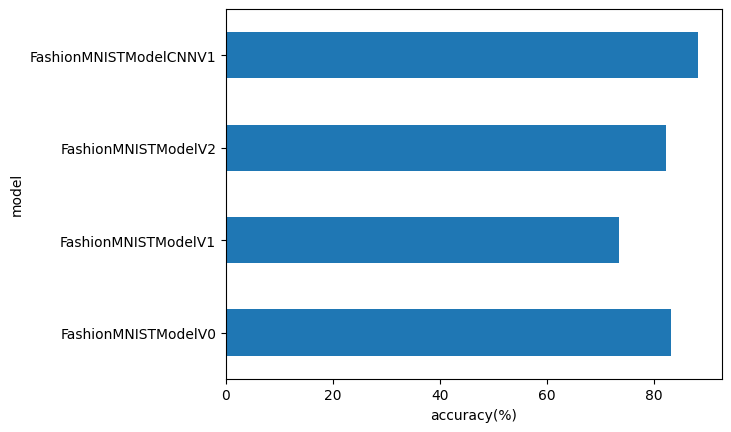

In [180]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

## Make predictions with best model

In [181]:
def make_predictions(model, data, device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [182]:
import random

test_samples, test_labels = [], []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [183]:
pred_probs = make_predictions(model=model_cnn_1, data=test_samples, device=device)
pred_probs[:2]

tensor([[2.3516e-08, 1.7014e-08, 1.0690e-09, 1.5262e-09, 3.4894e-09, 9.9979e-01,
         5.4605e-08, 8.1041e-08, 9.5370e-06, 1.9592e-04],
        [1.2525e-02, 9.3452e-01, 2.0000e-05, 1.9710e-02, 1.8976e-02, 8.1563e-06,
         1.2464e-02, 4.3540e-04, 4.8711e-04, 8.5580e-04]])

In [184]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [185]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

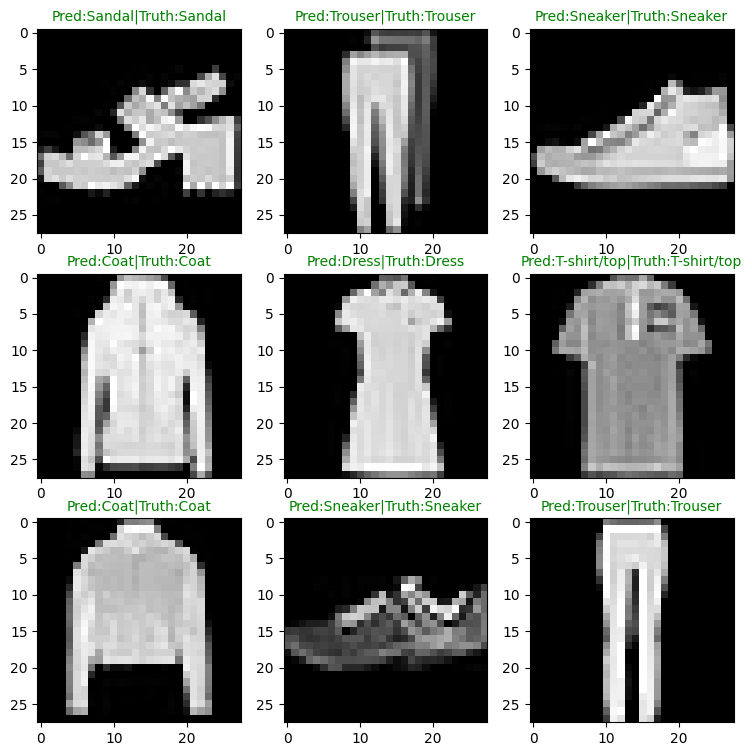

In [186]:
plt.figure(figsize=(9,9))
rows, cols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred:{pred_label}|Truth:{truth_label}"
    if pred_label == truth_label:
        plt.title(label=title_text, fontsize=10, c="g")
    else:
        plt.title(label=title_text, fontsize=10, c="r")

## Making a confusion matrix

It shows where your model gets confused between predictions and labels.

In [187]:
y_preds = []
model_cnn_1.eval()

with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_cnn_1(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

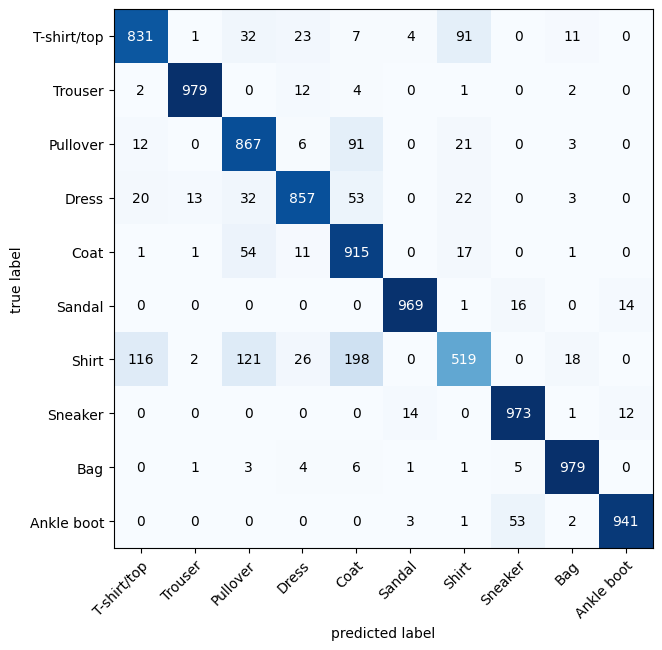

In [188]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))

## Save and load best performing model

In [189]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True,
                 parents=True)
MODEL_NAME = "03_pytorch_computer_vision_model_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model_cnn_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving to models/03_pytorch_computer_vision_model_cnn.pth


In [190]:
loaded_model = FashionMNISTModelCNNV1(input_shape=1,
                                      hidden_units=10,
                                      output_shape=10)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)

In [191]:
loaded_model_results = eval_model(model=loaded_model,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  acc_fn=accuracy_fn,
                                  device=device)
loaded_model_results

{'model_name': 'FashionMNISTModelCNNV1',
 'model_loss': 0.3346298336982727,
 'model_acc': 88.31869009584665}

In [192]:
torch.isclose(torch.tensor(model_cnn_1_result["model_loss"]),
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)